In [102]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [95]:
scored_hist = pd.read_csv("../data/scored_histograms.csv", index_col="Id")
query_hist = pd.read_csv("../data/query_histograms.csv", index_col="Id")
# scored_pca = pd.read_csv("../data/scored_features.csv", index_col="Id")
# query_pca = pd.read_csv("../data/query_features.csv", index_col="Id")
scored_hog = pd.read_csv("../data/scored_hog.csv", index_col="Id")
scored_hog.columns = [col + "_hog" for col in scored_hog.columns]
query_hog = pd.read_csv("../data/query_hog.csv", index_col="Id")
query_hog.columns = [col + "_hog" for col in query_hog.columns]

X = scored_hist.drop(columns=['Unnamed: 0', 'Actual'])
# X['pca'] = scored_hist.iloc[:, 1]
X = X.join(scored_hog)
y = pd.DataFrame(scored_hist['Actual'])

X_test = query_hist.drop(columns=['Unnamed: 0', 'Actual'])
# X_test['pca'] = query_hist.iloc[:, 1]
X_test = X_test.join(query_hog)

In [112]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.85)

In [114]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [104]:
hyperparams = {
    "clf__n_estimators": [30, 100, 500, 1000],
    "clf__max_depth": [6],
    "clf__colsample_bytree": [1],
#     "clf__reg_lambda": [1, 2],
#     "clf__reg_alpha" : [0, 1],
    "clf__objective": ["reg:squarederror"]
}

pipeline = Pipeline([('transformer', StandardScaler()),
                         ('clf', XGBRegressor())])

search = GridSearchCV(pipeline, hyperparams, cv=5, verbose=10, n_jobs=-1, refit=True, scoring=make_scorer(mean_absolute_error))
search.fit(X, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   52.5s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  4.7min remaining:  3.8min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  5.4min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  9.4min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 11.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 11.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('transformer',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('clf',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gbtree',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsample_bytree=1,
                                                     gamma=0,
                                                     importance_type='gain',
                                                     learning_rate=0.1,
                                     

In [105]:
search.__dict__

{'scoring': make_scorer(mean_absolute_error),
 'estimator': Pipeline(memory=None,
          steps=[('transformer',
                  StandardScaler(copy=True, with_mean=True, with_std=True)),
                 ('clf',
                  XGBRegressor(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0,
                               importance_type='gain', learning_rate=0.1,
                               max_delta_step=0, max_depth=3, min_child_weight=1,
                               missing=None, n_estimators=100, n_jobs=1,
                               nthread=None, objective='reg:linear',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, seed=None, silent=None,
                               subsample=1, verbosity=1))],
          verbose=False),
 'n_jobs': -1,
 'iid': 'deprecated',
 'refit': True,


In [115]:
clf = XGBRegressor(n_estimators=30, objective="reg:squarederror")
clf.fit(X_train, y_train)
predictions = clf.predict(X_val)
error = mean_absolute_error(y_val, predictions)
error

0.40643639509424695

In [110]:
cross_val_score(Pipeline([('transformer', StandardScaler()),
                         ('clf', XGBRegressor(n_estimators=30, objective="reg:squarederror"))]), X, y, scoring=make_scorer(mean_absolute_error), cv=5)

[11:44:24] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:44:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:44:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:44:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:45:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


array([0.37573253, 0.38217283, 0.36661058, 0.36651923, 0.36052447])

In [79]:
test_predictions = clf.predict(X_test)
output = pd.DataFrame(columns=["Predicted"])
output["Id"] = X_test.index
output["Predicted"] = test_predictions
output.set_index("Id", inplace=True)
output.to_csv("res.csv")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0c341c8278>]],
      dtype=object)

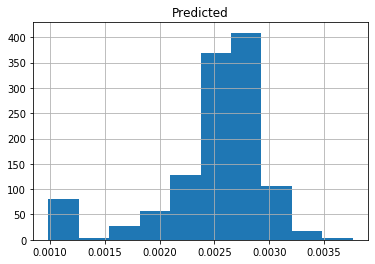

In [81]:
output.hist()